# Barcelona: the best neighborhood where to place a Japanese restaurant.

### Business problem

In this final project, our main goal is to find a good place where our client could open a Japanese restaurant. We will locate all the restaurants in every neighborhood and especially, the Japanese ones, and suggest a recommendation where this facility should run succesfully. This is, to find a place with low restaurant density and free of Japanese one's, if possible.

### Target audience

This study is aimed at anyone interested in opening a new business in Barcelona, but does not know the most appropriate place to open the business, or does not know the competition they will have. Although it is focused on the case of a client who wants to open a specific restaurant, with minor modifications it can be extended to any type of bussiness. 

### Data

We will use the Wikipedia data of Barcelona City (Catalonia, Spain). The coordinates of each borough can be found also in the Wikipedia, but they are dispersed in every borough webpage, so a Python rutine is necessary in order to collect all these data. Finaly, with Foursquare we will obtain all the restaurants of the city.

The main data of Barcelona neighborhoods have been taken from the Wikipedia site:

https://ca.wikipedia.org/wiki/Districtes_i_barris_de_Barcelona

where we can find the following table with the data we are looking for

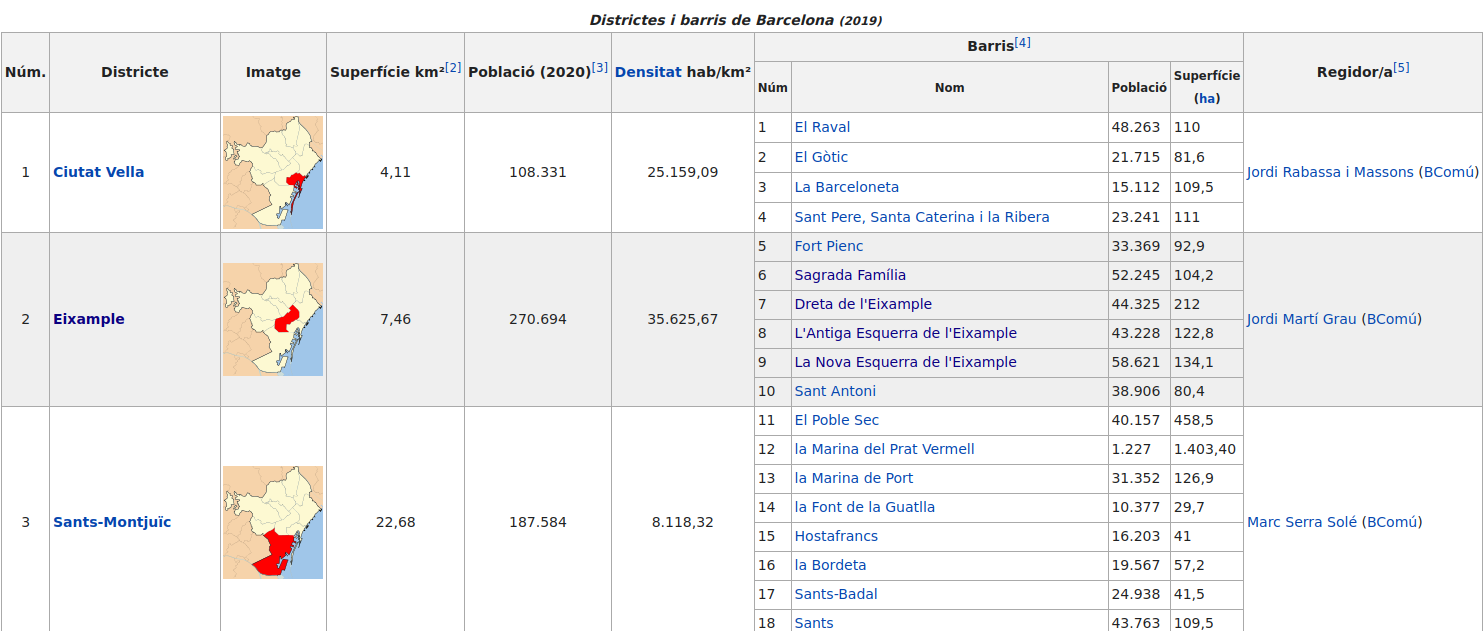

In [1]:
from IPython.display import Image
Image(filename="Figures/Captura 1.png")

Here we can find a table the following information:

* District
* Area (in km²)
* Population (in 2020)
* Population density (per km²)
* Borough
* Borough population (in 2020)
* Borough area (in km²)
* Number

Some data like the borough map or the borough governor's name ("Regidor/a"), have been removed because they are not necessary for our purposes.

The table data has also links for every borough to his own Wikipedia page. Here we can find, among other data, the latitude and longitude for each one, necessary in order to plot in a map. Because they are dispersed in every neighborough webpage, a Python routine is necessary in order to collect all these data. If we click in the "Nom" link, we will find the geographic coordinates:

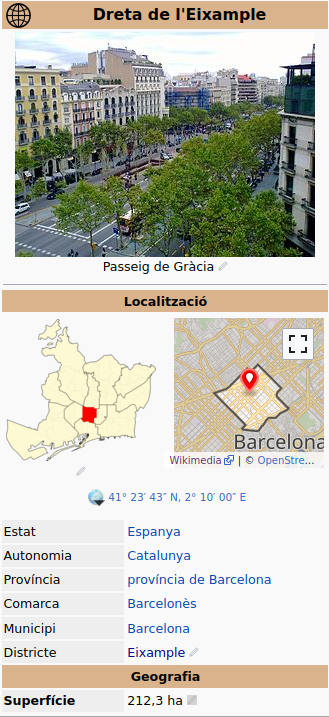

In [2]:
Image(filename="Figures/Captura 2.png")

Finaly, with Foursquare we will obtain all the restaurants of the city or, if needed, other city equipments.

At this moment the data is still being collected. Soon I will begin to work it.

## Code: import all needed libraries

In [3]:
import pandas as pd
import numpy as np

from bs4 import BeautifulSoup 
import requests  

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim

from pandas.io.json import json_normalize 
from IPython.display import Image

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes 
import folium 

In [4]:
# Data collect
url = "https://ca.wikipedia.org/wiki/Districtes_i_barris_de_Barcelona"

In [5]:
data = requests.get(url).text
soup = BeautifulSoup(data,"html5lib")

In [6]:
tables = soup.find_all('table')
len(tables)

3

In [7]:
for index,table in enumerate(tables):
    if ("Població (2020)" in str(table)):
        table_index = index
print(table_index)

0


In [8]:
print(tables[table_index].prettify())

<table border="1" class="bellataula">
 <caption>
  <i>
   <b>
    Districtes i barris de Barcelona
    <small>
     (2019)
    </small>
   </b>
  </i>
 </caption>
 <tbody>
  <tr bgcolor="silver">
   <th rowspan="2">
    <center>
     <b>
      Núm.
     </b>
    </center>
   </th>
   <th rowspan="2">
    <center>
     <b>
      Districte
     </b>
    </center>
   </th>
   <th rowspan="2">
    Imatge
   </th>
   <th rowspan="2">
    <center>
     <b>
      Superfície km²
     </b>
     <sup class="reference" id="cite_ref-2">
      <a href="#cite_note-2">
       [2]
      </a>
     </sup>
    </center>
   </th>
   <th rowspan="2">
    <center>
     <b>
      Població (2020)
     </b>
     <sup class="reference" id="cite_ref-3">
      <a href="#cite_note-3">
       [3]
      </a>
     </sup>
    </center>
   </th>
   <th rowspan="2">
    <center>
     <b>
      <a href="/wiki/Densitat_de_poblaci%C3%B3" title="Densitat de població">
       Densitat
      </a>
      hab/km²
     </b>
    <

In [9]:
table_contents=[]
table=soup.find('table')

for row in table.findAll('tr'):
    cell = {}   
    cols = row.find_all('td') 
    if len(cols) == 4:       
        cell['Number'] = cols[0].text.strip()
        cell['Borough'] = cols[1].text.strip()
        cell['Population'] = cols[2].text.strip().replace(".", "")
        cell['Area (ha)'] = cols[3].text.strip().replace(".", "").replace(",", ".")
    elif len(cols) == 11:
        cell['District'] = cols[1].text.strip()
        cell['Area (km2)'] = cols[3].text.strip().replace(",", ".")
        cell['Population (2020)'] = cols[4].text.strip().replace(".", "")
        cell['Density (per km2)'] = cols[5].text.strip().replace(".", "").replace(",", ".")
        cell['Borough'] = cols[7].text.strip()
        cell['Population'] = cols[8].text.strip().replace(".", "")
        cell['Area (ha)'] = cols[9].text.strip().replace(".", "").replace(",", ".")

    table_contents.append(cell)
    
# print(table_contents)
df=pd.DataFrame(table_contents)
df

,District,Area (km2),Population (2020),Density (per km2),Borough,Population,Area (ha),Number
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Ciutat Vella,4.11,108331,25159.09,El Raval,48263,110,NaN
3,NaN,NaN,NaN,NaN,El Gòtic,21715,81.6,2
4,NaN,NaN,NaN,NaN,La Barceloneta,15112,109.5,3
...,...,...,...,...,...,...,...,...
71,NaN,NaN,NaN,NaN,el Besòs i el Maresme,25501,118.5,70
72,NaN,NaN,NaN,NaN,Provençals del Poblenou,21523,108.6,71
73,NaN,NaN,NaN,NaN,Sant Martí de Provençals,26168,73.4,72
74,NaN,NaN,NaN,NaN,la Verneda i la Pau,28878,112.7,73


In [10]:
df.ffill(axis = 0, inplace = True) # fills NaN values with previous non NaN value for each column
df.dropna(inplace = True)
df[['Population (2020)', 'Population']] = df[['Population (2020)', 'Population']].astype("int")
df[['Area (km2)', 'Density (per km2)', 'Area (ha)']] = df[['Area (km2)', 'Density (per km2)', 'Area (ha)']].astype("float")
df[['District', 'Borough']] = df[['District', 'Borough']].astype("str")
df.reset_index(inplace = True, drop = True)
df.head(7)

,District,Area (km2),Population (2020),Density (per km2),Borough,Population,Area (ha),Number
0,Ciutat Vella,4.11,108331,25159.09,El Gòtic,21715,81.6,2
1,Ciutat Vella,4.11,108331,25159.09,La Barceloneta,15112,109.5,3
2,Ciutat Vella,4.11,108331,25159.09,"Sant Pere, Santa Caterina i la Ribera",23241,111.0,4
3,Eixample,7.46,270694,35625.67,Fort Pienc,33369,92.9,4
4,Eixample,7.46,270694,35625.67,Sagrada Família,52245,104.2,6
5,Eixample,7.46,270694,35625.67,Dreta de l'Eixample,44325,212.0,7
6,Eixample,7.46,270694,35625.67,L'Antiga Esquerra de l'Eixample,43228,122.8,8


In [11]:
df.dtypes

District              object
Area (km2)           float64
Population (2020)      int64
Density (per km2)    float64
Borough               object
Population             int64
Area (ha)            float64
Number                object
dtype: object